## Import Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Load Clean Data

In [19]:
# File paths (assumes these files exist locally in data/)
from pathlib import Path
DATA_DIR = Path('../data')
FILES = {
'Benin': DATA_DIR / 'benin_clean.csv',
'SierraLeone': DATA_DIR / 'sierraleone_clean.csv',
'Togo': DATA_DIR / 'togo_clean.csv'
}

In [21]:
# Load data
frames = []
for country, fpath in FILES.items():
    if not fpath.exists():
        raise FileNotFoundError(f"Required file not found: {fpath} (please ensure data/{fpath.name} exists)")
    df = pd.read_csv(fpath)
    df['Country'] = country
    # Ensure timestamp parsing if exists
    if 'Timestamp' in df.columns:
        try:
            df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        except Exception:
            pass
    frames.append(df)


# Concatenate
df_all = pd.concat(frames, ignore_index=True)

In [27]:
df_all.head()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Country
0,2021-08-09 00:01:00,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,Benin
1,2021-08-09 00:02:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,Benin
2,2021-08-09 00:03:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,Benin
3,2021-08-09 00:04:00,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,Benin
4,2021-08-09 00:05:00,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,Benin


## 1. Metric Comparison
---

### 1.1.Boxplots of GHI, DNI, DHI side-by-side (one plot per metric, colored by country).

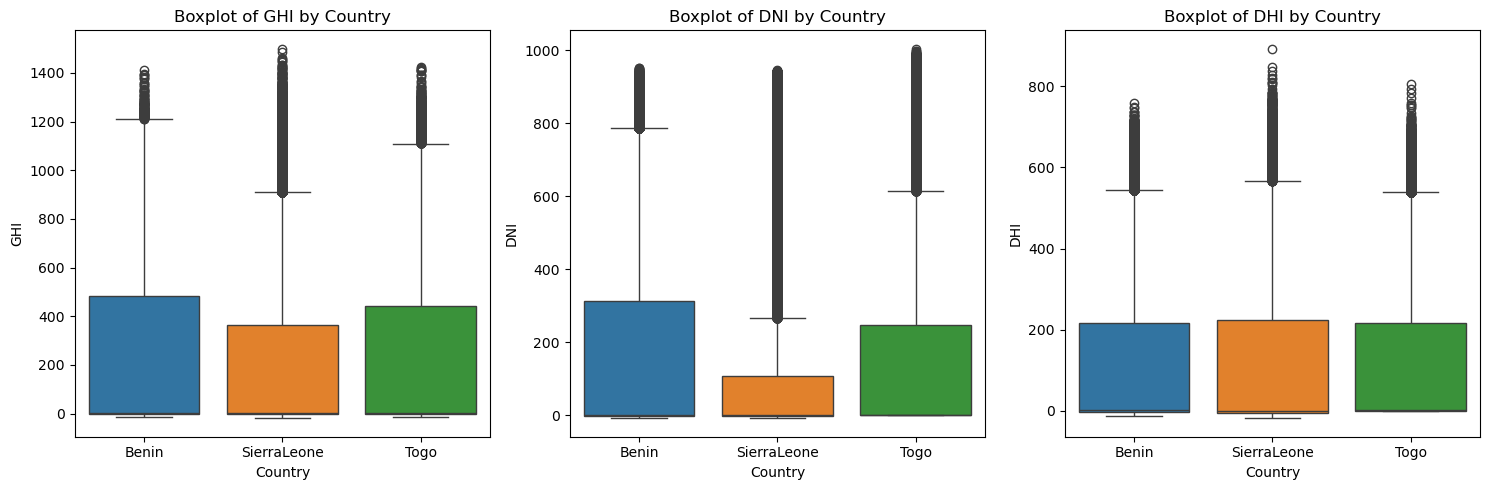

In [57]:
metrics = ['GHI', 'DNI', 'DHI']

plt.figure(figsize=(15, 5))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    # Boxplot of the metric, grouped by Country
    sns.boxplot(x='Country', y=metric, data=df_all, hue='Country')
    plt.title(f'Boxplot of {metric} by Country')
    
plt.tight_layout()
plt.show()

### 1.2. Summary Table comparing mean, median, and standard deviation of GHI, DNI, DHI across countries.

In [79]:
summary_table = df_all.groupby('Country')[metrics].agg(['mean', 'median', 'std']).reset_index()
# Flatten the column names for a cleaner look
summary_table.columns = ['Country', 'GHI_mean', 'GHI_median', 'GHI_std', 
                        'DNI_mean', 'DNI_median', 'DNI_std', 
                          'DHI_mean', 'DHI_median', 'DHI_std']

print("Summary Table")
print(summary_table.to_markdown())

Summary Table
|    | Country     |   GHI_mean |   GHI_median |   GHI_std |   DNI_mean |   DNI_median |   DNI_std |   DHI_mean |   DHI_median |   DHI_std |
|---:|:------------|-----------:|-------------:|----------:|-----------:|-------------:|----------:|-----------:|-------------:|----------:|
|  0 | Benin       |    240.559 |          1.8 |   331.131 |    167.188 |         -0.1 |   261.711 |    115.359 |          1.6 |   158.691 |
|  1 | SierraLeone |    201.958 |          0.3 |   298.495 |    116.376 |         -0.1 |   218.653 |    113.721 |         -0.1 |   158.946 |
|  2 | Togo        |    230.555 |          2.1 |   322.532 |    151.258 |          0   |   250.957 |    116.444 |          2.5 |   156.521 |


## 2. Statistical Testing 
---

### 2.1. One-way ANOVA (or Kruskal–Wallis) on GHI values to assess whether differences between countries are significant

In [106]:
# Prepare the data for ANOVA: a list of GHI series, one for each country
ghi_per_country = [group['GHI'] for name, group in df_all.groupby('Country')]

# Run the One-way ANOVA
f_stat, p_anova = stats.f_oneway(*ghi_per_country)
h_stat, p_kruskal = stats.kruskal(*ghi_per_country)

print("Statistical Testing: One-way ANOVA and Kruskal-Wallis on GHI")
print(f"Anova: F-stat={f_stat:.4f}, P-value-anova={p_anova:.4e}")
print(f"Kruskal-Wallis: H-stat={h_stat:.4f}, P-value-kruskal={p_kruskal:.4e}")

Statistical Testing: One-way ANOVA and Kruskal-Wallis on GHI
Anova: F-stat=2090.0929, P-value-anova=0.0000e+00
Kruskal-Wallis: H-stat=4524.8835, P-value-kruskal=0.0000e+00


### 2.2. P-values

In [110]:
if p_anova < 0.05:
    print("Conclusion: The p-value is less than 0.05. We reject the Null Hypothesis, suggesting there is a **statistically significant difference** in the mean GHI between at least some of the countries.")
else:
    print("Conclusion: The p-value is greater than 0.05. We fail to reject the Null Hypothesis, suggesting there is **no statistically significant difference** in the mean GHI between the countries.")

Conclusion: The p-value is less than 0.05. We reject the Null Hypothesis, suggesting there is a **statistically significant difference** in the mean GHI between at least some of the countries.


## 3. Key Observations

* **Benin Exhibits Highest Overall Mean Irradiance**: Benin has the highest mean values across all three metrics: GHI_mean (240.56 W/m²), DNI_mean (167.19 W/m²), and DHI_mean (115.36 W/m²). This suggests that, on average, Benin receives the strongest solar resource potential among the three countries.
* **Extreme Variability in Measurements**: All countries show extremely low median values (close to zero or even negative) combined with very high standard deviations (GHI_std ranging from 298 to 331 W/m²). This indicates that the vast majority of readings are close to zero (likely taken during nighttime or extreme cloud cover), while the mean is inflated by a smaller number of very high daytime readings.This high variability suggests the data likely includes 24-hour readings and exhibits high day-to-night variance.
* **Sierra Leone Has the Lowest Direct Solar Potential**: Sierra Leone reports the lowest mean GHI and DNI. Notably, its DNI_mean (116.38 W/m²) is the smallest compared to Benin and Togo, making it less suitable for systems that rely heavily on direct sunlight.

## 4. Visual Summary
---

### Small bar chart ranking countries by average GHI.

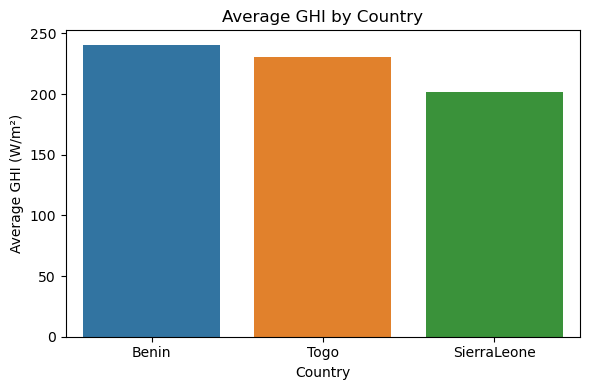

In [125]:
avg_ghi = df_all.groupby('Country')['GHI'].mean().sort_values(ascending=False).reset_index()
plt.figure(figsize=(6,4))
sns.barplot(data=avg_ghi, x='Country', y='GHI', hue='Country')
plt.title('Average GHI by Country')
plt.ylabel('Average GHI (W/m²)')
plt.tight_layout()
plt.show()